In [1]:
import torch
import config
import numpy as np
import matplotlib.pyplot as plt
import os
from Alg.solving_algorithm import ModelGenerator
from CustomModels.my_models import Integrator
from CustomModels.my_models import weighted_amount,renormolize_distribution
from aml.plotting import *
from Losses.Losses import *
from sklearn import decomposition
from tqdm import tqdm
from scipy.spatial import ConvexHull

def adjust_alpha(alpha_n):
    for j in range(len(alpha_n)):
        if alpha_n[j]<0.0:
            alpha_n[j] = 0.0
        elif alpha_n[j] > 1.0:
            alpha_n[j] = 1.0
    alpha_n = alpha_n/np.sum(alpha_n)
    return alpha_n 

def Temp(k,T_0,max_iter):
    # return T_0/np.log(k+2)
    # return T_0/k
    a = -T_0/max_iter
    b = T_0
    return a*k+b

def ProbOfChangeToNewParams(L_new, L_old, beta, current_temp):
    H_ = 0.0
    if L_new < L_old:
        H_ = 1.0
    else:
        H_=  np.minimum(1.0,np.exp((L_old-L_new)/(beta*current_temp)))
        # H_ = 0.0
    return H_

def UpdateMu(mu_current,mu_new,epsilon,ProbOfUpdate):
    if ProbOfUpdate == 1.0:
        # new_ = epsilon*mu_current + (1-epsilon)*mu_new
        new_ = mu_new
        new_ = new_/np.sum(new_)
        return  new_, True
    if ProbOfUpdate == 0.0:
        return  mu_current, False
    
    v_ = ProbOfUpdate*1000
    coin_=  np.random.randint(0,1001)
    if coin_ <= v_:
        new_ = mu_new
        # new_ = epsilon*mu_current + (1-epsilon)*mu_new
        new_ = new_/np.sum(new_)
        return new_, True
    else:
        return mu_current,False
        
def GenAlphaVec(mu_current, value_of_noise):
    noise = np.random.rand(len(mu_current))
    noise = noise/np.sum(noise)
    new_ = (1.0-value_of_noise)*mu_current + value_of_noise* noise
    new_ = new_/np.sum(new_)
    return new_

def adjust_alpha(alpha_n):
    for j in range(len(alpha_n)):
        if alpha_n[j]<0.0:
            alpha_n[j] = 0.001
        elif alpha_n[j] > 1.0:
            alpha_n[j] = 1.0
    alpha_n = alpha_n/np.sum(alpha_n)
    return alpha_n 

def grad_descent_from_alpha(alpha_vec,p_0, shared_integration_supports,a,board,exp_meta,
                            MAX_ITER,MAX_GENERATIONS,T_0):
    d= len(alpha_vec)   
    alpha_n = np.copy(alpha_vec)
    alpha_n = alpha_n/np.sum(alpha_n)
    p_n = renormolize_distribution(p_0,a,alpha_n)
    L_n = get_L2_Distrib4D(p_n, shared_integration_supports)

    for ITER in range(MAX_ITER):
        board.Push(experiment_metadata=exp_meta,
        x=ITER,y= L_n, label='L')
        if ITER % 10 ==0:
            print('ITER {} L_n {}'.format(ITER,L_n))
            # print(alpha_n)
        else:
            print('ITER {} L_n {}'.format(ITER,L_n))

        p_n=  renormolize_distribution(p_n,a,alpha_n)
        L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
        gradient_ = np.zeros(shape=(d,))
        epsilon_ = 10**(-1)
        for j in range(d):
            if alpha_n[j] < epsilon_:
                alpha_1 = np.copy(alpha_n)
                alpha_1[j] = alpha_1[j] + epsilon_
                p_1 = renormolize_distribution(p_n,a,alpha_1)
                L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
                gradient_[j] = (L_1 - L_n)/epsilon_
                continue
            if alpha_n[j] > 1.0-epsilon_:
                alpha_2 = np.copy(alpha_n)
                alpha_2[j] = alpha_2[j] - epsilon_
                p_2 = renormolize_distribution(p_n,a,alpha_2)
                L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
                gradient_[j] = (L_n-L_2)/epsilon_
                continue

            alpha_1 = np.copy(alpha_n)
            alpha_1[j] = alpha_1[j] + epsilon_
            alpha_2 = np.copy(alpha_n)
            alpha_2[j] = alpha_2[j] - epsilon_

            p_1 = renormolize_distribution(p_n,a,alpha_1)
            p_2 = renormolize_distribution(p_n,a,alpha_2)

            L_1 = get_L2_Distrib4D(p_1,shared_integration_supports)
            L_2 = get_L2_Distrib4D(p_2,shared_integration_supports)
            gradient_[j] = (L_1 - L_2)/(2*epsilon_)
        board.Push(experiment_metadata=exp_meta,
        x=ITER,y= np.linalg.norm(gradient_), label='grad norm')
        lambda_vec = np.logspace(start=4,stop=-4,num=10)
        lambda_best = None
        loss_current = L_n
        ls = []
        lambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = renormolize_distribution(p_n,a,alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            ls.append(L_after)
            lambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
        arg_best = np.argsort(ls)[0]
        left_pos = np.maximum(0, arg_best-1)
        right_pos = np.minimum(len(ls)-1, arg_best+1)

        left = lambda_ls[left_pos]
        right = lambda_ls[right_pos]

        lambda_vec = np.linspace(left,right,10)
        addls = []
        addlambda_ls = []
        for lambda_ in lambda_vec:
            alpha_copy = np.copy(alpha_n)
            alpha_after = alpha_copy - lambda_*gradient_
            if np.sum(alpha_after < 0.0)==d:
                continue
            alpha_after = adjust_alpha(alpha_after)        
            p_after = renormolize_distribution(p_n,a,alpha_after)
            L_after = get_L2_Distrib4D(p_after,shared_integration_supports)
            addls.append(L_after)
            addlambda_ls.append(lambda_)
            if L_after<loss_current:
                loss_current = L_after
                lambda_best = lambda_
        if lambda_best == None:
            alpha_n = alpha_n + epsilon_*np.random.rand(d)
            alpha_n = alpha_n/np.sum(alpha_n)
        else:
            fig,ax = plt.subplots()
            ax.plot(lambda_ls, ls)
            ax.set_xscale('log')
            plt.show()

            alpha_n = alpha_n - lambda_best*gradient_
            alpha_n = adjust_alpha(alpha_n)
            print(alpha_n)
            torch.save(alpha_n, os.path.join(config.task_dir,'alpha_rules_descent.txt'))
    p_n = renormolize_distribution(p_n,a,alpha_n)
    return p_n, L_n,alpha_n


In [2]:


# alpha_best_ = None
# T_n = T_0
# p_n = p_0
# L_best = 10**99
# L_current = 10**99
# # all_losses = []
# # while True:
# #     p_n=  renormolize_distribution(p_n,a,alpha_n)
# #     L_n = get_L2_Distrib4D(p_n,shared_integration_supports)
    
# #     n +=1    
# l_all = []
# for ITER in tqdm(range(MAX_ITER)):
#     sigma_n = T_n/T_0
#     for j in range(MAX_GENERATIONS):
#         alpha_ = GenAlphaVec(mu_current=alpha_n, value_of_noise=0.3*sigma_n)
#         p_ = renormolize_distribution(p_n, a, alpha_)
#         L_new = get_L2_Distrib4D(p_,shared_integration_supports)
#         H_ = ProbOfChangeToNewParams(L_new,L_current, 1.0,T_n)
#         board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= H_, label='H')
#         alpha_updated, is_update = UpdateMu(alpha_n,alpha_,epsilon=0.8,ProbOfUpdate=H_)
#         if is_update:
#             board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= L_new, label='L')

#         if is_update and (L_new<L_current):
#             L_current = L_new
#             alpha_n = alpha_updated
#             break
#         elif is_update and not (L_new<L_current):
#             L_current = L_new
#             alpha_n = alpha_updated

#         if L_new < L_best:
#             L_best = L_new
#             alpha_best_ = np.copy(alpha_updated)
#     if ITER % 10 ==0:
#         print(alpha_n)
#     T_n = Temp(ITER,T_0,MAX_ITER)
#     board.Push(experiment_metadata=exp_meta,
#             x=ITER,y= T_n, label='T')
# p_n = renormolize_distribution(p_n,a,alpha_n)
# return p_n, L_current,alpha_n

def approx_equal(x1,x2,precision):
    if np.absolute(x1-x2) < precision:
        return True
    else:
        return False

In [3]:
board = TensorBoard(tensorboard_exe_path=config.tensorboard_path,
                    logdir=os.path.join(config.task_dir, 'rules_descent_log'),
                    port= '64001')

tensorboard http://localhost:64001/


In [4]:
mg = ModelGenerator(rules=config.rules,
                            cache_dir=config.Phi_cache_dir,
                            clear_cache=False)
shared_integration_supports = Integrator(dir_=config.integrator_dir,
                                        shared_data=mg.shared_data,
                                        clear_cache=True).shared_integration_supports
N=1000
all_p = [torch.load(os.path.join(mg.cache_dir, 'distrib4D_{}.txt'.format(i))) for i in range(N)]
all_v=  torch.load(os.path.join(config.task_dir, 'L2_for_Phi.txt'))
nr = len(all_p[0].z_list)
uniform_distrib_of_rules= np.ones(shape=(nr,))/nr
a, h, f, coeff_list = mg.shared_data['ahfcoeff_list']
a = [a[el].detach().numpy() for el in range(len(a))]
for i in range(N):
    all_p[i] = renormolize_distribution(all_p[i],a,uniform_distrib_of_rules)

     num_of_rect_in_intersection 17090


choose start distribtuion by random choise

In [5]:
# p_0 = all_p[np.argmin(all_v)]
p_0_pos = np.random.randint(0,N)
print(p_0_pos)
p_0 = all_p[p_0_pos]


379


make gradiend descent on distribution in $R^{n_{r}}$

In [6]:
exp_metadata = 'gradien_descent'+get_time()
board.InitExperiment(experiment_metadata= exp_metadata)

In [7]:
alpha_n = np.copy(uniform_distrib_of_rules)
T_0 = 0.002
MAX_GENERATIONS = 1000
MAX_ITER = 300

ITER 0 L_n 0.8386629227993179


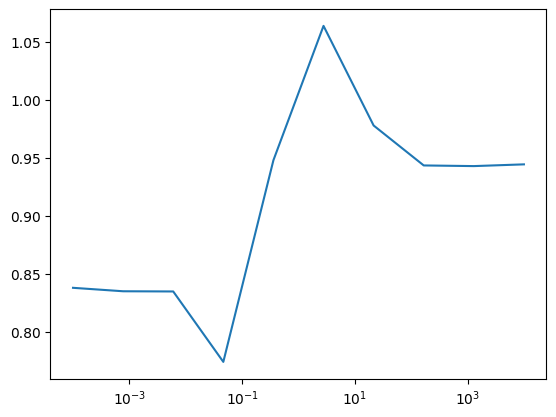

[0.02137228 0.02142432 0.02173082 0.02194549 0.02182752 0.02112325
 0.02109572 0.02149463 0.02183996 0.02307958 0.02167798 0.02131451
 0.02121409 0.02112489 0.02178681 0.02106444 0.01891094 0.01406268
 0.02016535 0.02128307 0.02138239 0.02182172 0.02224001 0.00103677
 0.02865613 0.00103677 0.02222759 0.02136687 0.02158886 0.02250042
 0.02190359 0.01228155 0.01820086 0.02118303 0.02159971 0.02122949
 0.02137388 0.02281307 0.02268386 0.02140691 0.02053387 0.02174052
 0.0211114  0.02121077 0.02152347 0.02172141 0.02112298 0.0217828
 0.02118094]
ITER 1 L_n 0.8386629227993179


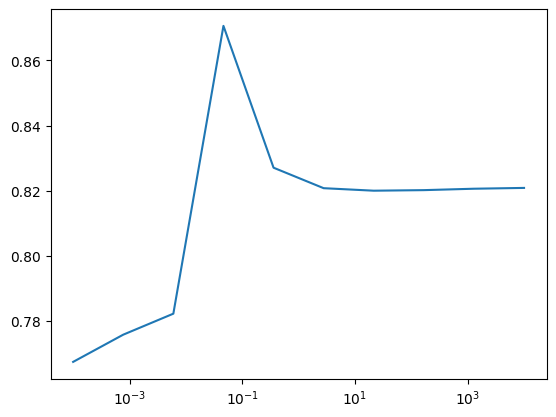

[0.02138713 0.02144093 0.02174692 0.02196016 0.02184282 0.02113849
 0.02111041 0.0215091  0.02185516 0.02309823 0.02169187 0.02133239
 0.02123126 0.0211407  0.02180228 0.02107807 0.01888139 0.01404823
 0.02016013 0.0212991  0.02139888 0.02183779 0.02225527 0.00085251
 0.02862482 0.00080421 0.02224755 0.0213817  0.02160443 0.02251751
 0.02187178 0.01225443 0.01813695 0.02119586 0.02161495 0.02124456
 0.02138985 0.02283102 0.02269808 0.02141988 0.0205476  0.02175584
 0.02112614 0.02122617 0.02153852 0.02173696 0.02113798 0.02179805
 0.02119592]
ITER 2 L_n 0.7739010061461212
ITER 3 L_n 0.7673813248074013


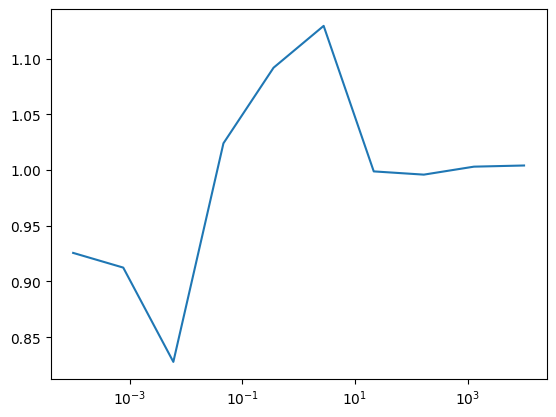

[0.01888124 0.02552937 0.00844342 0.02593644 0.026465   0.01260758
 0.01318641 0.02051518 0.03477782 0.03208082 0.01830946 0.01127643
 0.02328553 0.01716775 0.02733663 0.01341201 0.02782495 0.00672718
 0.0296558  0.02326906 0.03123575 0.01903907 0.00807964 0.01645976
 0.04062444 0.00065104 0.02641543 0.01235531 0.03395656 0.02274733
 0.0294538  0.00231659 0.02413832 0.01648107 0.02236136 0.00604479
 0.01441113 0.03473716 0.01607332 0.01352275 0.03055806 0.01672162
 0.01327601 0.00619738 0.03153364 0.02761165 0.01852568 0.03266045
 0.01512278]
ITER 4 L_n 0.9200087888885914
ITER 5 L_n 0.8255315142505768


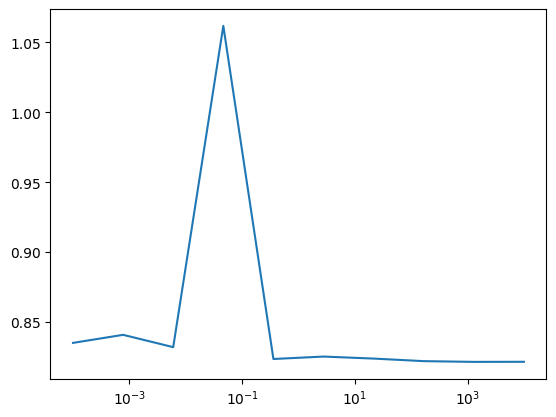

[7.73291245e-02 7.73291245e-05 7.73291245e-05 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-02
 7.73291245e-05 7.73291245e-05 7.73291245e-02 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-02 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-05
 7.73291245e-02 7.73291245e-02 7.73291245e-05 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-02
 7.73291245e-02 7.73291245e-02 7.73291245e-02 7.73291245e-05
 7.73291245e-05 7.73291245e-05 7.73291245e-05 7.73291245e-05
 7.73291245e-02 7.73291245e-02 6.92666577e-02 7.73291245e-05
 7.73291245e-05]
ITER 6 L_n 0.82734349178364


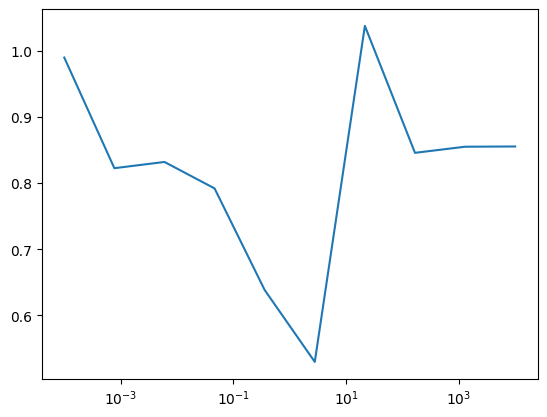

[0.03168829 0.00035963 0.00035963 0.01218629 0.01472457 0.00035963
 0.00035963 0.03775848 0.00035963 0.00035963 0.01115264 0.03023188
 0.07645696 0.00035963 0.03503891 0.00035963 0.00035963 0.00035963
 0.00035963 0.07190119 0.01951495 0.03681451 0.00035963 0.00035963
 0.35963316 0.00035963 0.00035963 0.0042591  0.00035963 0.0264228
 0.00035963 0.00035963 0.00035963 0.00035963 0.00245487 0.0205562
 0.02599059 0.05416203 0.02483581 0.00548072 0.00035963 0.00035963
 0.00035963 0.00077683 0.02572753 0.03510482 0.01481124 0.00434822
 0.00969586]
ITER 7 L_n 0.8212137034770968
ITER 8 L_n 0.5297377345396437


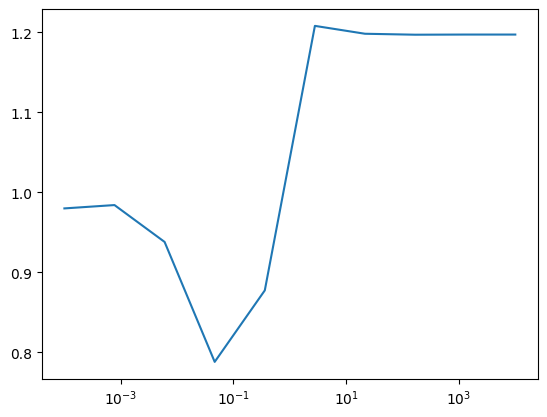

[0.0179218  0.02384068 0.03079365 0.01711373 0.0303054  0.01158957
 0.01653302 0.02144654 0.01060916 0.03257249 0.00106394 0.02350237
 0.03501373 0.03329102 0.00978481 0.00106394 0.00106394 0.00106394
 0.00106394 0.03608664 0.01993977 0.01853709 0.00106394 0.00106394
 0.1373914  0.00106394 0.01246237 0.01952362 0.01698077 0.01596703
 0.05169667 0.02264178 0.00106394 0.02539518 0.01851736 0.02746313
 0.02853972 0.03834083 0.01366103 0.00106394 0.01850521 0.00195201
 0.02592795 0.00711466 0.03754382 0.04084063 0.00863061 0.00958083
 0.02180251]
ITER 9 L_n 0.9719703798845538
ITER 10 L_n 0.7613301663127316


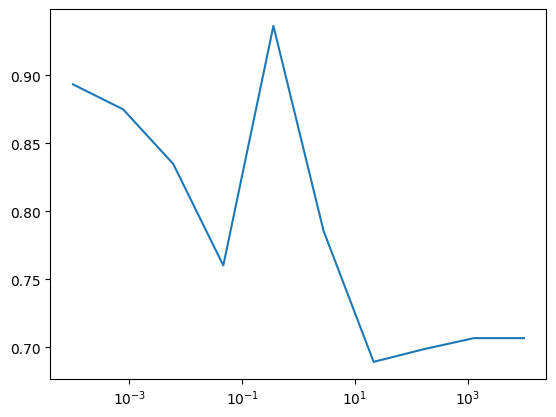

[7.17269956e-05 7.17269956e-05 7.17269956e-05 7.17269956e-05
 7.17269956e-05 2.31731458e-02 7.17269956e-05 7.17269956e-05
 7.17269956e-05 7.17269956e-05 7.17269956e-02 2.17213877e-02
 7.17269956e-05 1.11306156e-02 7.17269956e-05 7.17269956e-05
 7.17269956e-05 7.17269956e-02 7.17269956e-05 5.38217878e-02
 7.17269956e-05 2.39696064e-02 7.17269956e-02 7.17269956e-05
 7.17269956e-05 7.17269956e-05 1.87489595e-02 7.17269956e-05
 7.08594502e-03 3.64015926e-03 7.17269956e-02 7.17269956e-02
 7.17269956e-02 7.17269956e-05 9.29233323e-03 7.72953201e-04
 7.17269956e-05 6.64750086e-02 7.17269956e-02 7.17269956e-02
 7.17269956e-05 9.80339211e-03 6.51206907e-04 8.52711921e-03
 2.21949755e-02 7.17269956e-02 7.17269956e-02 7.17269956e-05
 7.17269956e-05]
ITER 11 L_n 0.8913100576662926
ITER 12 L_n 0.6892113401136727


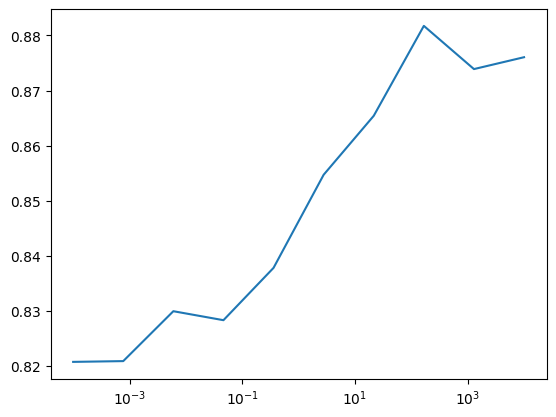

[2.74672758e-02 1.17766108e-02 2.90884657e-03 2.73545358e-02
 1.24541772e-02 1.94407956e-02 2.31770200e-02 2.95001323e-03
 2.07011297e-02 1.52088534e-02 2.87145853e-02 6.53023079e-03
 1.45541653e-02 1.91805776e-02 5.18446865e-05 1.77069840e-02
 1.10158910e-02 3.23882786e-02 2.12592222e-02 2.14000820e-02
 6.43800506e-03 7.75459154e-03 2.57658686e-02 1.98969111e-02
 2.19740881e-02 1.37260980e-02 2.59797179e-02 6.99378138e-03
 2.03295049e-02 6.81324077e-03 4.73587071e-02 4.33772816e-02
 3.26163952e-02 1.55239025e-02 2.98271996e-02 1.41919658e-02
 2.29180319e-02 3.77040371e-02 4.46651189e-02 2.94856138e-02
 8.28818657e-03 2.76458457e-02 2.48999254e-02 1.26563880e-02
 3.37074792e-02 2.12090992e-02 3.52509298e-02 1.67282743e-02
 1.00326913e-02]
ITER 13 L_n 0.8238160887701702


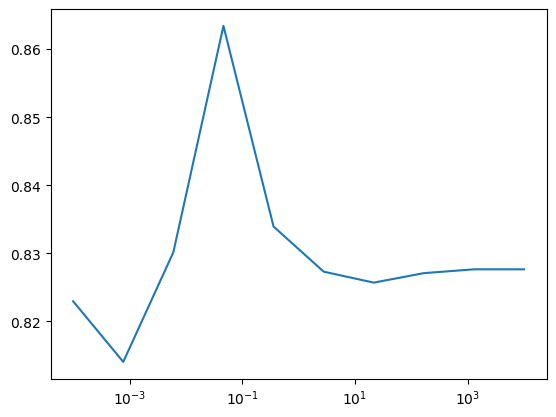

[2.75040756e-02 1.18014002e-02 2.92977196e-03 2.73895895e-02
 1.24733786e-02 1.94680568e-02 2.32018070e-02 2.95459376e-03
 2.07355384e-02 1.52426662e-02 2.87844583e-02 6.57047991e-03
 1.45970009e-02 1.92176062e-02 7.01345658e-05 1.76740788e-02
 1.08549021e-02 3.22513811e-02 2.12574068e-02 2.14446340e-02
 6.44756675e-03 7.78650352e-03 2.58208210e-02 1.97341352e-02
 2.19035156e-02 1.35530343e-02 2.60277415e-02 7.01850174e-03
 2.03365736e-02 6.82327575e-03 4.72235823e-02 4.34129640e-02
 3.24249132e-02 1.55034321e-02 2.98785350e-02 1.42029644e-02
 2.29302988e-02 3.77390411e-02 4.47260907e-02 2.95052365e-02
 8.25853719e-03 2.76874149e-02 2.49267825e-02 1.26557767e-02
 3.37208888e-02 2.12301068e-02 3.53027109e-02 1.67613204e-02
 1.00347740e-02]
ITER 14 L_n 0.8182529861644577


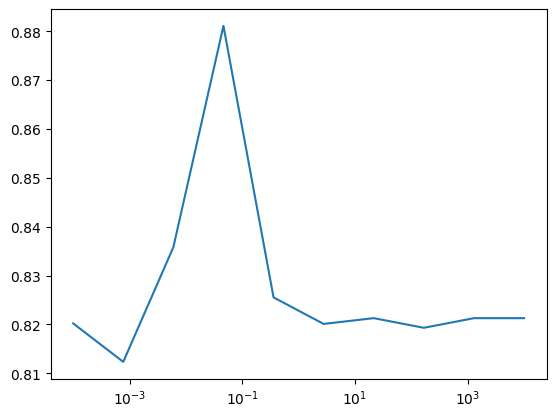

[2.75217828e-02 1.17851738e-02 2.94188936e-03 2.74049206e-02
 1.25051676e-02 1.94903875e-02 2.32322510e-02 2.96773968e-03
 2.07198209e-02 1.52922397e-02 2.88694087e-02 6.63911427e-03
 1.46325988e-02 1.92378895e-02 9.38283614e-05 1.76707018e-02
 1.07185442e-02 3.21600155e-02 2.12633331e-02 2.15138620e-02
 6.45954466e-03 7.81088376e-03 2.58992269e-02 1.95476141e-02
 2.18057462e-02 1.33630486e-02 2.60591594e-02 7.07001107e-03
 2.03712166e-02 6.85318776e-03 4.70416893e-02 4.33051596e-02
 3.22708829e-02 1.54739759e-02 2.99581844e-02 1.42311191e-02
 2.29642634e-02 3.78260093e-02 4.47764411e-02 2.94748655e-02
 8.22958786e-03 2.77212157e-02 2.49597175e-02 1.26679008e-02
 3.37678523e-02 2.12659355e-02 3.53371042e-02 1.67871895e-02
 1.00405976e-02]
ITER 15 L_n 0.8140539090443688


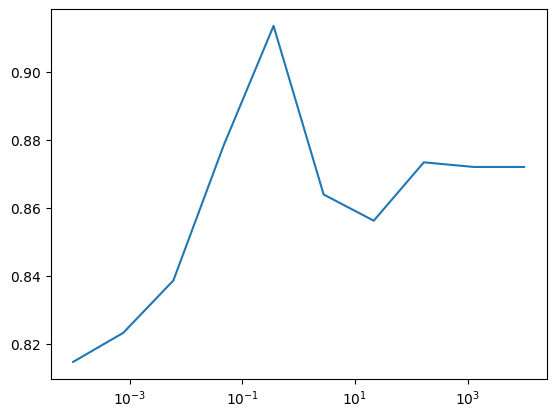

[0.02753935 0.01178489 0.00294371 0.02743185 0.0125201  0.01951751
 0.02325158 0.00297375 0.02071492 0.01528242 0.02886962 0.00663522
 0.01464745 0.01926406 0.00010405 0.01765013 0.01068592 0.03219092
 0.02122717 0.0215293  0.00647661 0.00782945 0.02591355 0.01947385
 0.02175884 0.01324714 0.02606693 0.00708522 0.02039207 0.00686082
 0.04699608 0.04327445 0.03213739 0.01545736 0.02997348 0.0142437
 0.02298472 0.03786598 0.04481007 0.02947764 0.00819998 0.02774523
 0.0249806  0.01268207 0.03380844 0.02128766 0.03536405 0.01679725
 0.01004546]
ITER 16 L_n 0.8123300518187238


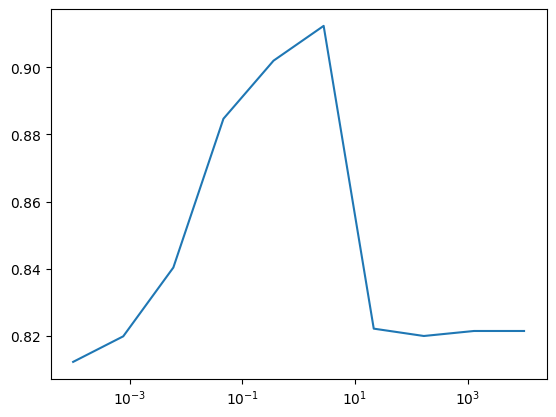

[0.02755543 0.01180964 0.00296087 0.02746653 0.01253464 0.01953946
 0.02327271 0.00298255 0.02072696 0.01530463 0.028903   0.00665239
 0.01468114 0.01928369 0.00013714 0.01765736 0.01059312 0.03221922
 0.02115507 0.02155153 0.00648648 0.00786031 0.02597096 0.01939367
 0.02169143 0.0131149  0.02609688 0.00711051 0.02039166 0.00688059
 0.04688936 0.04321803 0.03196944 0.01542818 0.03001361 0.01424758
 0.02300969 0.0379107  0.044848   0.02947593 0.00816898 0.02777306
 0.02500345 0.01268583 0.03383002 0.02128824 0.03540987 0.01680235
 0.01004323]
ITER 17 L_n 0.8109106555018457


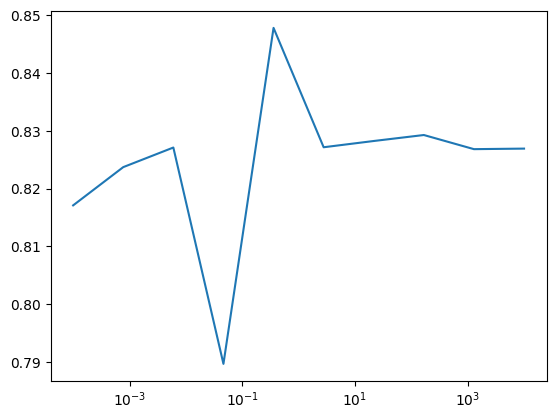

[0.03230165 0.01063424 0.00119187 0.03038745 0.01414477 0.0232891
 0.02766976 0.00347811 0.0198069  0.01253076 0.0303279  0.00649624
 0.01589976 0.02244775 0.00103095 0.01469546 0.00119187 0.03466637
 0.01819456 0.02262423 0.00685163 0.01257605 0.02575613 0.00508828
 0.01097244 0.00119187 0.03012317 0.00836988 0.02449098 0.01090891
 0.03886247 0.03406417 0.0063397  0.01387617 0.03524779 0.01817296
 0.02713351 0.046708   0.05448382 0.03024355 0.00279561 0.03295899
 0.02974377 0.01430415 0.03982593 0.02617285 0.04075054 0.01752969
 0.01144729]
ITER 18 L_n 0.8046469328648708


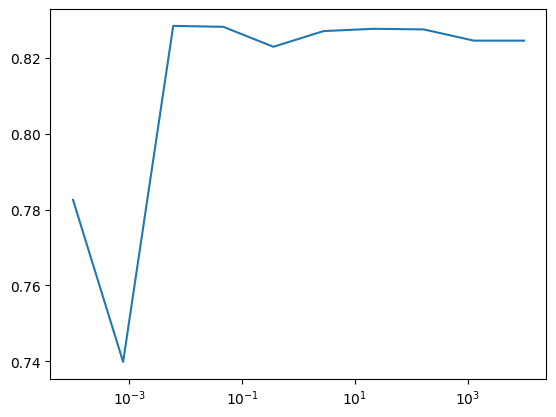

[0.03251278 0.01071906 0.0012041  0.03057961 0.01424062 0.02345108
 0.02786573 0.0035015  0.01987953 0.01259848 0.03051352 0.0065578
 0.01598888 0.02260631 0.00103903 0.01456845 0.00110212 0.03354119
 0.01783964 0.02278454 0.00693974 0.0126428  0.02588912 0.0047624
 0.01027168 0.00081882 0.03037289 0.008448   0.02464236 0.01090865
 0.03897167 0.03286859 0.00539218 0.01375527 0.03546452 0.01831394
 0.02728798 0.04702131 0.05483473 0.03036258 0.00269313 0.03316894
 0.02995468 0.01442815 0.04008085 0.02638303 0.0410762  0.01762938
 0.01152244]
ITER 19 L_n 0.7896838609827206
ITER 20 L_n 0.7398513013691027


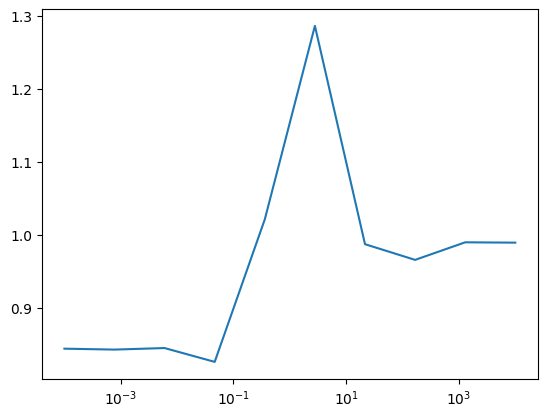

[0.02398424 0.00820485 0.01943211 0.0164067  0.01940107 0.00653426
 0.02934994 0.02136415 0.02703662 0.02365355 0.02571453 0.02787742
 0.01726265 0.01174561 0.02005396 0.02195903 0.00873229 0.00882003
 0.03097253 0.03398266 0.02145758 0.00641758 0.017105   0.01750714
 0.02342141 0.00879114 0.02806921 0.02134825 0.01859517 0.0066266
 0.03829215 0.02655207 0.00385003 0.02183945 0.01785815 0.03193131
 0.02651537 0.03471106 0.03583161 0.00871477 0.02584336 0.02005653
 0.00939996 0.01581609 0.01543827 0.02070254 0.03801753 0.01740925
 0.0193932 ]
ITER 21 L_n 0.8399816521484941


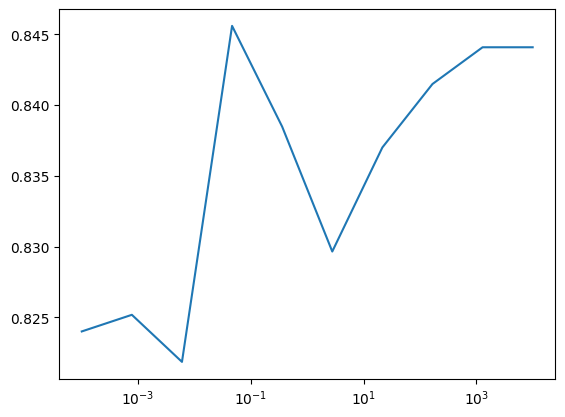

[0.02457922 0.00847921 0.01984586 0.01685194 0.01986578 0.00670129
 0.030032   0.02189906 0.02776604 0.02419576 0.02646984 0.02862074
 0.01773708 0.01204992 0.02049363 0.022282   0.0081907  0.0041714
 0.03091987 0.03490513 0.02197306 0.0066723  0.01729667 0.00793046
 0.02072325 0.00554721 0.02886521 0.02187709 0.01906739 0.00681579
 0.0393509  0.02585205 0.00360841 0.02238161 0.01836085 0.03269106
 0.02702229 0.03553476 0.03657658 0.00889207 0.02661754 0.02057734
 0.00961492 0.01618296 0.01582765 0.02128037 0.03898265 0.01799507
 0.01982603]
ITER 22 L_n 0.8255698713113125


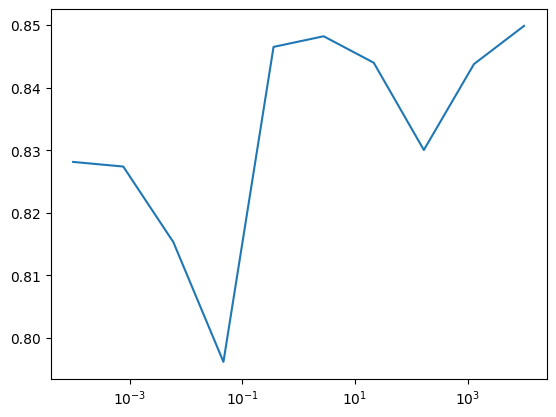

[0.02571182 0.00926358 0.02136606 0.01801762 0.02149984 0.00699385
 0.03132419 0.02284442 0.02903895 0.02414981 0.02815987 0.03137533
 0.0192116  0.01242723 0.02119101 0.02286121 0.00104542 0.0165495
 0.0242413  0.03550858 0.02315659 0.00764899 0.01796522 0.00104542
 0.00104542 0.00104542 0.02792543 0.02278476 0.02042019 0.00877095
 0.04467738 0.01279303 0.00170979 0.02253472 0.01906187 0.03445897
 0.02782246 0.03880793 0.03783781 0.00876546 0.02859716 0.02144059
 0.01000161 0.0170122  0.01698615 0.02323869 0.04083606 0.0183058
 0.02052277]
ITER 23 L_n 0.8218633487763877


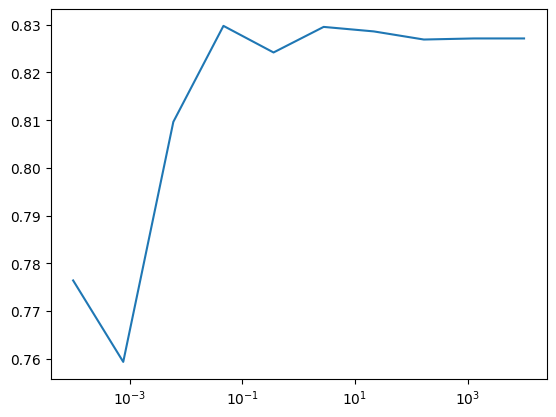

[0.02580125 0.00928189 0.02146405 0.01813699 0.02160454 0.00702358
 0.03144023 0.02294354 0.02924354 0.02421025 0.02833952 0.03149101
 0.01926637 0.01247213 0.02122403 0.02303468 0.00075834 0.01637349
 0.02415038 0.03563173 0.02323837 0.00763899 0.01797693 0.00067504
 0.00067798 0.00063809 0.02795186 0.02287937 0.02050657 0.00881786
 0.04427893 0.01195603 0.00157817 0.02255198 0.01912404 0.03457561
 0.02792409 0.03893303 0.03799185 0.00871015 0.02865222 0.02149486
 0.01003825 0.01706398 0.01705475 0.02328891 0.04090882 0.01840833
 0.02057341]
ITER 24 L_n 0.7961487342218908
ITER 25 L_n 0.7545262744621971


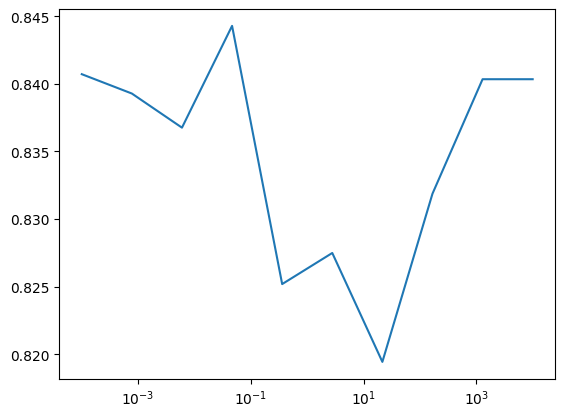

[7.57768081e-05 7.57768081e-05 7.57768081e-05 7.57768081e-02
 7.57768081e-05 7.57768081e-05 7.57768081e-05 6.87218958e-02
 7.57768081e-05 7.57768081e-05 4.17122887e-02 7.57768081e-02
 7.57768081e-05 7.57768081e-05 7.57768081e-05 7.57768081e-05
 7.57768081e-05 7.57768081e-05 7.57768081e-05 5.07411178e-02
 1.84524405e-02 7.57768081e-05 3.43354899e-02 7.57768081e-05
 7.57768081e-05 7.57768081e-05 7.57768081e-02 6.60684012e-02
 7.57768081e-05 4.84184053e-03 1.05696918e-02 7.57768081e-05
 7.57768081e-05 6.16033815e-02 7.57768081e-02 1.98986206e-02
 1.94135193e-02 1.46880740e-02 2.91313495e-02 7.57768081e-05
 7.57768081e-02 7.57768081e-05 7.57768081e-05 7.84541765e-03
 3.85968554e-02 7.57768081e-02 5.00802419e-02 6.66832811e-03
 7.57768081e-05]
ITER 26 L_n 0.8393002959451689
ITER 27 L_n 0.8150918144314186


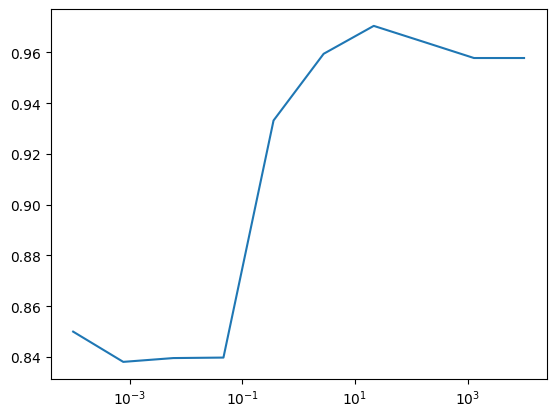

[0.02336127 0.02110935 0.00982016 0.04327268 0.0040484  0.00631186
 0.01982141 0.02487047 0.01129956 0.00707718 0.02505158 0.04337327
 0.02146024 0.01096586 0.01361698 0.01432959 0.01160555 0.02331465
 0.01376732 0.02841717 0.02783292 0.02081666 0.01418953 0.02110718
 0.00532992 0.01160684 0.0443883  0.02547249 0.02464338 0.02620913
 0.01125235 0.02483304 0.00362785 0.03123794 0.02878141 0.01253644
 0.01278646 0.0219796  0.00903461 0.01591153 0.0362331  0.00944856
 0.0230577  0.02672859 0.03232887 0.03216538 0.0364742  0.02475095
 0.00834053]
ITER 28 L_n 0.8522004080643458


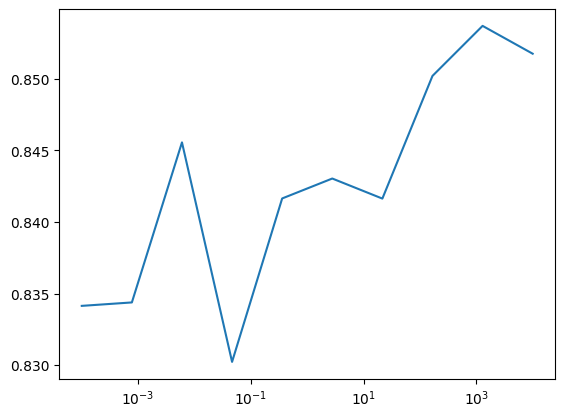

[0.02413064 0.03009013 0.01929739 0.0423113  0.00561534 0.00703298
 0.02109081 0.02745158 0.02034093 0.00107349 0.02071689 0.04412796
 0.02444743 0.01042806 0.01320413 0.00107349 0.00746288 0.00107349
 0.02475062 0.03642266 0.02745992 0.02235252 0.01459952 0.00107349
 0.00388255 0.00107349 0.0474241  0.03696288 0.0290973  0.036206
 0.00107349 0.04582727 0.00107349 0.0264099  0.03823284 0.01965711
 0.01971485 0.0312672  0.00665581 0.01383222 0.02313226 0.01331967
 0.02454418 0.02796433 0.03009014 0.03135542 0.02451589 0.01540249
 0.00365749]
ITER 29 L_n 0.8352487433390422


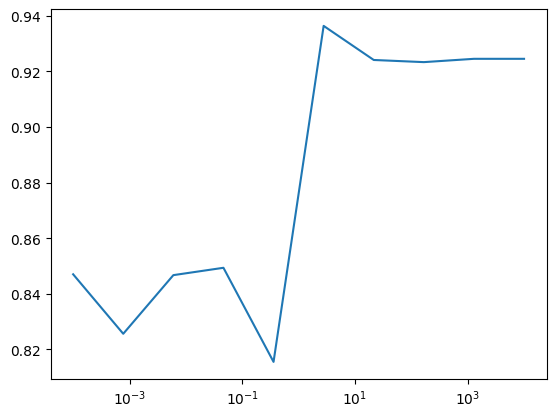

[0.02258257 0.02978032 0.00820429 0.05339658 0.00808091 0.01662718
 0.02496835 0.02640677 0.0012004  0.0012004  0.03335005 0.04205138
 0.03683084 0.01846665 0.0203002  0.0012004  0.0012004  0.00812405
 0.08226715 0.01753423 0.04380533 0.02285609 0.00195486 0.0012004
 0.0012004  0.0012004  0.0012004  0.04484199 0.01471803 0.05789301
 0.0012004  0.0012004  0.0012004  0.0012004  0.02524463 0.01918078
 0.02325057 0.03658518 0.04472695 0.01425932 0.01025049 0.00111569
 0.02909358 0.04513318 0.02867449 0.04476779 0.01482184 0.00842298
 0.00502688]
ITER 30 L_n 0.8215976561031866


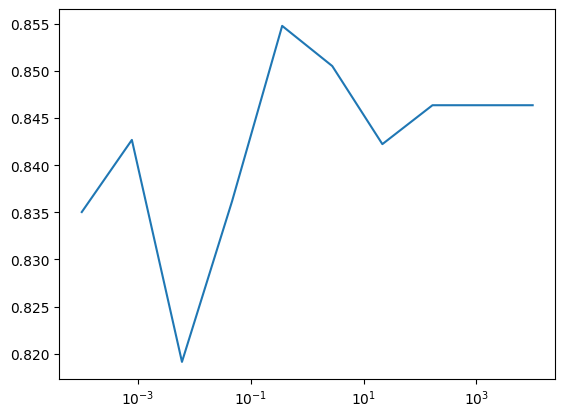

[0.02283286 0.0298378  0.00854107 0.0541182  0.00811974 0.01680271
 0.0252578  0.02655051 0.00019492 0.00087861 0.0332155  0.04267332
 0.03734486 0.01867017 0.02038659 0.00101188 0.00101188 0.00101188
 0.08167984 0.01785383 0.04439689 0.02282422 0.00224335 0.00101188
 0.00101188 0.00101188 0.00101188 0.04548644 0.01486724 0.05841235
 0.00101188 0.00374804 0.00101188 0.00101188 0.02550449 0.01934887
 0.02340743 0.03697566 0.0450577  0.0142415  0.0093884  0.00109146
 0.02943148 0.04552066 0.02897484 0.04526553 0.01509022 0.00859622
 0.00504983]
ITER 31 L_n 0.8100629016499806
ITER 32 L_n 0.8069532824010491


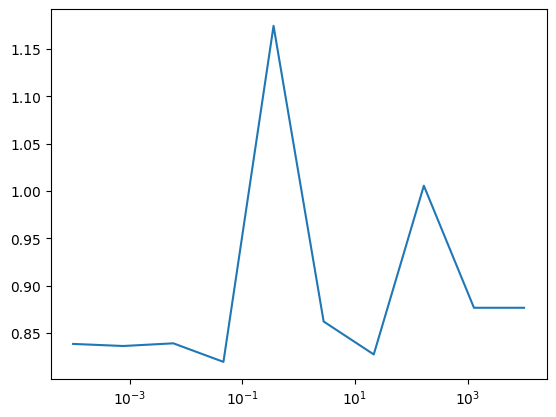

[0.00906264 0.03929645 0.0272932  0.04819327 0.01256729 0.01874383
 0.02437105 0.02146908 0.00951459 0.005662   0.01581762 0.0305939
 0.04260652 0.00599107 0.02575051 0.01012646 0.0130659  0.01034388
 0.02923641 0.031015   0.0288329  0.01598772 0.02801739 0.00099063
 0.05373701 0.00099063 0.00303061 0.03756077 0.00913661 0.03393805
 0.01533113 0.01935995 0.01917602 0.00066443 0.01519059 0.00919059
 0.02020679 0.03502235 0.04490122 0.02683928 0.00111108 0.01621517
 0.0173817  0.03118193 0.01948566 0.04501623 0.01196678 0.00753434
 0.00128176]
ITER 33 L_n 0.8430914578826649


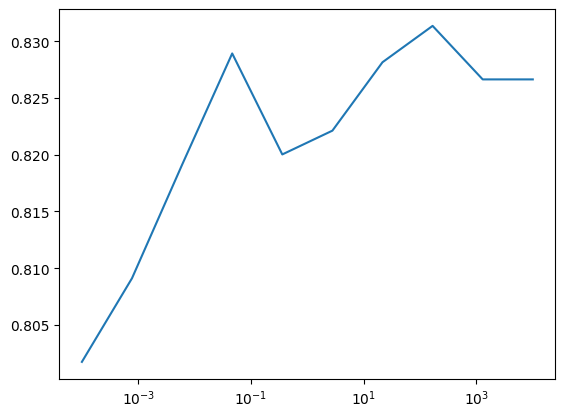

[0.00908589 0.03939419 0.02737217 0.048317   0.01260058 0.01878967
 0.02443218 0.02152335 0.00952895 0.00566658 0.01585679 0.03067611
 0.04271552 0.00600677 0.02581343 0.01015478 0.01305098 0.01019077
 0.02914611 0.03109018 0.02890477 0.01603283 0.02807661 0.00038697
 0.05336554 0.00057103 0.00303109 0.03766458 0.00916335 0.0340241
 0.01525304 0.01911628 0.01914807 0.0006532  0.01522202 0.0092146
 0.02025343 0.03510912 0.0450128  0.02687949 0.00108857 0.0162489
 0.01742514 0.03126021 0.01953558 0.04512425 0.01198385 0.00755713
 0.00128145]
ITER 34 L_n 0.7971527123518052


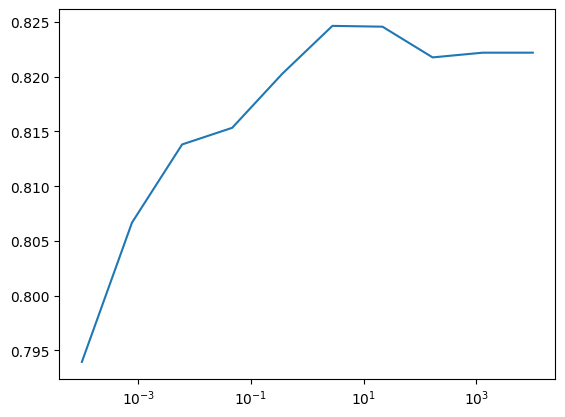

[9.09807743e-03 3.94475051e-02 2.74098895e-02 4.83834744e-02
 1.26197823e-02 1.88157221e-02 2.44651647e-02 2.15543660e-02
 9.54652911e-03 5.67392164e-03 1.58800982e-02 3.07198354e-02
 4.27743531e-02 6.01530879e-03 2.58450123e-02 1.01712831e-02
 1.30081242e-02 1.00976190e-02 2.91266426e-02 3.11311821e-02
 2.89442004e-02 1.60526315e-02 2.81069917e-02 5.11403632e-05
 5.31688417e-02 3.29611208e-04 3.02792696e-03 3.77127910e-02
 9.17537088e-03 3.40712821e-02 1.52402778e-02 1.89927113e-02
 1.91140981e-02 6.42223178e-04 1.52391680e-02 9.22812954e-03
 2.02786610e-02 3.51603737e-02 4.50777976e-02 2.69108188e-02
 1.08053452e-03 1.62613631e-02 1.74485820e-02 3.13032270e-02
 1.95654023e-02 4.51880566e-02 1.19976579e-02 7.56757531e-03
 1.27866329e-03]
ITER 35 L_n 0.7953801012851922
ITER 36 L_n 0.7919113270456914


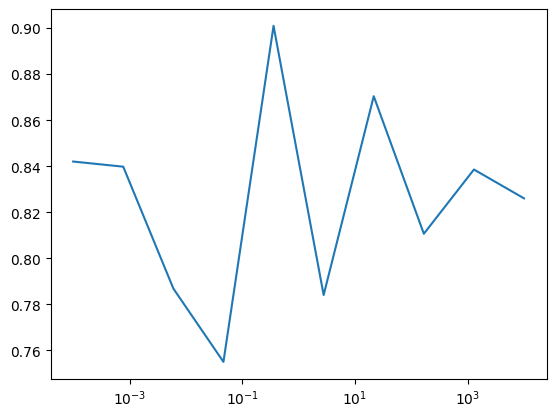

[0.02647908 0.02652646 0.00990201 0.02909746 0.01572119 0.02295729
 0.02054257 0.02684172 0.00082185 0.00082185 0.02530861 0.02613023
 0.01790209 0.01714618 0.01603547 0.02262957 0.01833088 0.07330022
 0.06799254 0.01313235 0.02202062 0.0039061  0.02862506 0.00082185
 0.00082185 0.00082185 0.00541652 0.00861001 0.00247336 0.02110248
 0.05642208 0.09916693 0.00466703 0.00593102 0.02489918 0.01708906
 0.01831089 0.0343469  0.00717118 0.01117812 0.00124623 0.01941145
 0.01295753 0.0171436  0.03158221 0.03676791 0.00437829 0.0154316
 0.00965947]
ITER 37 L_n 0.8383912185737568
ITER 38 L_n 0.7524730706769371


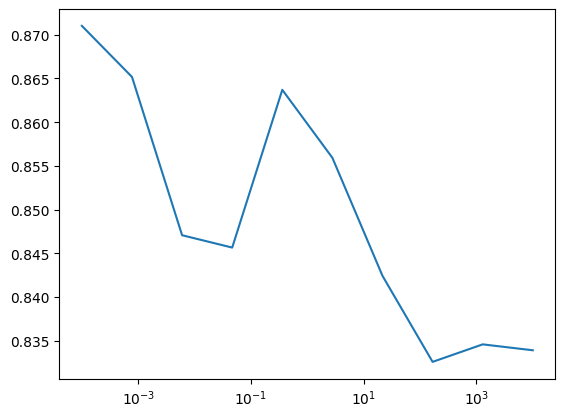

[2.26570725e-03 3.61837758e-05 3.61837758e-02 3.61837758e-02
 3.61837758e-02 3.61837758e-05 3.61837758e-05 3.61837758e-05
 4.09943947e-03 3.61837758e-02 3.61837758e-02 3.61837758e-02
 6.24703269e-03 1.96148639e-02 3.61837758e-02 3.61837758e-02
 3.61837758e-02 3.61837758e-02 3.61837758e-02 3.61837758e-02
 3.61837758e-05 3.61837758e-02 3.61837758e-02 3.61837758e-02
 3.61837758e-02 3.61837758e-02 3.61837758e-02 3.61837758e-02
 3.61837758e-05 3.61837758e-05 3.61837758e-02 3.61837758e-02
 3.61837758e-02 3.61837758e-05 3.61837758e-02 3.61837758e-05
 3.61837758e-05 3.61837758e-02 3.61837758e-02 3.61837758e-05
 3.61837758e-05 2.06105306e-02 3.61837758e-05 1.25378505e-03
 3.61837758e-05 1.82237850e-02 3.61837758e-05 3.61837758e-05
 2.25115205e-02]
ITER 39 L_n 0.872330224939022


KeyboardInterrupt: 

In [8]:
p_best, l_best,alpha_n = grad_descent_from_alpha(alpha_n, p_0, shared_integration_supports,a,board,exp_metadata,MAX_ITER,MAX_GENERATIONS,T_0)